# Identify drougths using Brun et.al. 
- Emine Didem Durukan (emine.didem.durukan@ibm.com)
- Selene Ledain (selene.ledain@ibm.com)

Approach:
compare NDVI signal before/after drought
- what amount of anomaly reflects a dorught
- what difference in NDVI

Poly: [5.9015720629374897,46.0996747818851205 : 8.8389538566414583,47.7676884241931106] (I think this is the study area)
- CRS: EPSG:4326 - WGS 84
- 47.729804,8.640668 point in schaffhausen

- Another box in Schaffhausen = [8.64029,47.72969, 8.64370, 47.73234]
- box in vaud = [6.488905,46.667063,6.495100, 46.669420]


In [1]:
import geopandas as gpd
import fiona
from rasterio.mask import mask
from shapely.geometry import box
import json
import os
import re
import pandas as pd
import rasterio
from rasterio.windows import from_bounds
import numpy as np
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from shapely import wkt

/u/seleneledain/.conda/envs/drought2/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


## Schaffhausen

## 1. Open data in bbox

In [2]:
bbox =  [8.64029,47.72969, 8.64370, 47.73234] 
coords = "47.586_8.397_47.807_8.756" # Schaffhausen

In [8]:
def create_forest_mask(bbox, coords):
    forest_threshold = 0.95 #ratio of forest per pixel

    # Create forest mask --> Use the one in valais!
    forest_mask = f'/dccstor/cimf/drought_impact/downloads/forest_mask/{coords}/Drought-Continuous forest mask-11_03_2022T00_00_00.tiff'
    if bbox is not None:
        with rasterio.open(forest_mask) as src:
            im_forest = rasterio.open(forest_mask)
        for_arr = im_forest.read(1,  window=from_bounds(bbox[0], bbox[1], bbox[2], bbox[3], src.transform))
    else:
        with rasterio.open(forest_mask) as src:
            im_forest = rasterio.open(forest_mask)
        for_arr = im_forest.read(1)

    for_arr[for_arr==-9999] = np.nan

    # Make binary mask keeping only pixels that are >50% forest
    forest_binary = for_arr.copy()
    forest_binary[np.isnan(forest_binary)]=0
    forest_binary[forest_binary<forest_threshold]=0
    forest_binary[forest_binary!=0]=1
    forest_binary = (forest_binary==1)

    # Get coordinates of forest pixel in bbox
    with rasterio.open(forest_mask) as src:
        im_forest = rasterio.open(forest_mask)
        for_arr = im_forest.read(1,  window=from_bounds(bbox[0], bbox[1], bbox[2], bbox[3], src.transform))
        print('shape of bbox:', for_arr.shape)
        height = for_arr.shape[0]
        width = for_arr.shape[1]
        bbox_transform = rasterio.transform.from_bounds(bbox[0], bbox[1], bbox[2], bbox[3], width, height)
        cols, rows = np.meshgrid(np.arange(width), np.arange(height))
        xs, ys = rasterio.transform.xy(bbox_transform, rows, cols)
        lons = np.concatenate(xs).ravel()
        lats = np.concatenate(ys).ravel()

    # Select forest pixels
    forest_indices = np.where(forest_binary.flatten() == True)
    row_pixs = forest_indices[0]
    col_pixs = forest_indices[0]
    lons = lons[col_pixs]
    lats = lats[row_pixs]

    df_coords = pd.DataFrame({'lons':lons, 'lats': lats})

    # Create point geometries
    gdf = gpd.GeoDataFrame(df_coords, geometry=gpd.points_from_xy(df_coords['lons'], df_coords['lats']), crs="EPSG:4326")
    
    return forest_binary, gdf


def get_ndvi_and_bands_coords(coords, forest_binary, bbox, gdf):
    """
    Get NDVI pixels in bounding box if cloud proba < cp_thresh, sampling only forest pixels using the firet mask
    :param coords: coords of Valais patch to filter folders
    :param cp_thresh: cloud proba threshold. Drop measurement if its proba is above 
    :param gdf: GeoDataFrae containing cooridnates of all forest pixels in bbox
    :param forest_binary: forest mask
    :param bbox: boudning box to read data from
    """
    
    data_path = '/dccstor/cimf/drought_impact/downloads/SENTINEL 2'
    df_NDVI = pd.DataFrame()

    for folder in os.listdir(data_path):
        if coords in folder:
            timestamp = datetime.strptime(folder.split('Z')[0], '%Y-%m-%dT%H:%M:%S')
            for file in os.listdir(data_path + '/' + folder):

                ndvi_search = '\[' +  'NDVI' + '\]'
                cp_search =  '\[' + 'CP' + '\]'
                b2_search =  '\[' + 'B02' + '\]'
                b8_search =  '\[' + 'B08' + '\]'

                if (file.endswith('.tiff') & bool(re.search(f'{ndvi_search}',file))): 
                    with rasterio.open(data_path + '/' + folder + '/' + file) as src:
                        ndvi = src.read(1, window=from_bounds(bbox[0], bbox[1], bbox[2], bbox[3], src.transform))

                if (file.endswith('.tiff') & bool(re.search(f'{cp_search}',file))): 
                    with rasterio.open(data_path + '/' + folder + '/' + file) as src:
                        cloud = src.read(1, window=from_bounds(bbox[0], bbox[1], bbox[2], bbox[3], src.transform))
                        
                if (file.endswith('.tiff') & bool(re.search(f'{b2_search}',file))): 
                    with rasterio.open(data_path + '/' + folder + '/' + file) as src:
                        b2 = src.read(1, window=from_bounds(bbox[0], bbox[1], bbox[2], bbox[3], src.transform))
                        
                if (file.endswith('.tiff') & bool(re.search(f'{b8_search}',file))): 
                    with rasterio.open(data_path + '/' + folder + '/' + file) as src:
                        b8 = src.read(1, window=from_bounds(bbox[0], bbox[1], bbox[2], bbox[3], src.transform))
                        
                        
            # Mask out forest, clouds and -9999 (as nan)
            cloud[cloud == -9999] = np.nan
            ndvi[ndvi == -9999] = np.nan
            b2[b2 == -9999] = np.nan
            b8[b8 == -9999] = np.nan

            df_file = pd.DataFrame({'timestamp': [timestamp]*len(ndvi[forest_binary].flatten()), 'ndvi': ndvi[forest_binary].flatten(), 
                                    'cp':cloud[forest_binary].flatten(), 'b2':b2[forest_binary].flatten(), 'b8':b8[forest_binary].flatten(), coords:gdf.geometry}) 
            df_file = df_file.dropna(axis=0)
            
            df_NDVI = pd.concat([df_NDVI, df_file], axis=0, ignore_index=True) 

    return df_NDVI

In [9]:
# Create forest mask and get forest pixels coordinates
forest_binary, gdf = create_forest_mask(bbox, coords)

shape of bbox: (10, 13)


In [10]:
# Get raster data in bbox and in forest
df_NDVI = get_ndvi_and_bands_coords(coords, forest_binary, bbox, gdf)
df_NDVI['year'] = df_NDVI['timestamp'].dt.year
df_NDVI['day'] = df_NDVI['timestamp'].dt.dayofyear
df_NDVI = df_NDVI.rename(columns={f'{coords}':'coords'})
df_NDVI['month'] = df_NDVI['timestamp'].dt.month
df_NDVI['wkt'] = df_NDVI.coords.apply(lambda x: x.to_wkt())

# 2. Analyse data
- compare 2017 and 2018
- look at number of anomalies

In [11]:
df_NDVI

,timestamp,ndvi,cp,b2,b8,coords,year,day,month,wkt
0,2017-02-09,0.0643,100.0,0.3979,0.4652,POINT (8.64042 47.73221),2017,40,2,POINT (8.6404211538461535 47.7322075000000012)
1,2017-02-09,0.0721,100.0,0.3623,0.4233,POINT (8.64068 47.73221),2017,40,2,POINT (8.6406834615384618 47.7322075000000012)
2,2017-02-09,0.0736,100.0,0.3367,0.4000,POINT (8.64095 47.73221),2017,40,2,POINT (8.6409457692307683 47.7322075000000012)
3,2017-02-09,0.0714,100.0,0.3142,0.3781,POINT (8.64121 47.73221),2017,40,2,POINT (8.6412080769230766 47.7322075000000012)
4,2017-02-09,0.0835,100.0,0.3203,0.3789,POINT (8.64147 47.73221),2017,40,2,POINT (8.6414703846153849 47.7322075000000012)
...,...,...,...,...,...,...,...,...,...,...
33655,2020-12-30,0.0271,100.0,1.4992,1.4516,POINT (8.64252 47.72982),2020,365,12,POINT (8.6425196153846162 47.7298224999999974)
33656,2020-12-30,0.0297,100.0,1.5210,1.4666,POINT (8.64278 47.72982),2020,365,12,POINT (8.6427819230769227 47.7298224999999974)
33657,2020-12-30,0.0314,100.0,1.5428,1.4748,POINT (8.64304 47.72982),2020,365,12,POINT (8.6430442307692310 47.7298224999999974)
33658,2020-12-30,0.0290,100.0,1.5357,1.4654,POINT (8.64331 47.72982),2020,365,12,POINT (8.6433065384615393 47.7298224999999974)


### 2017 vs 2018

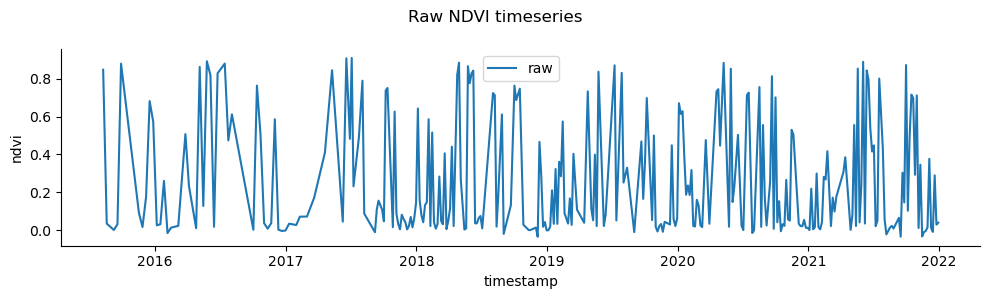

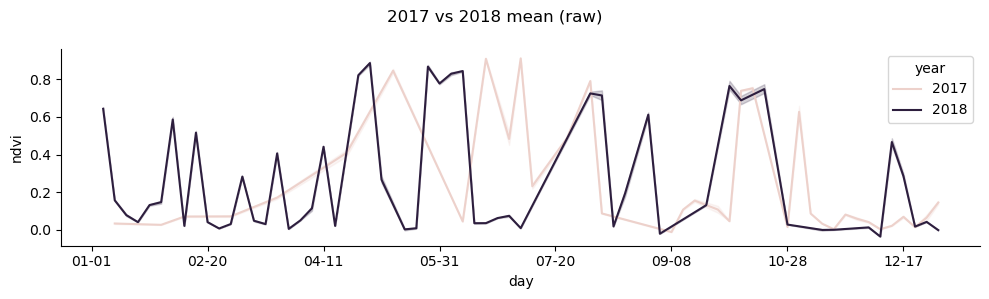

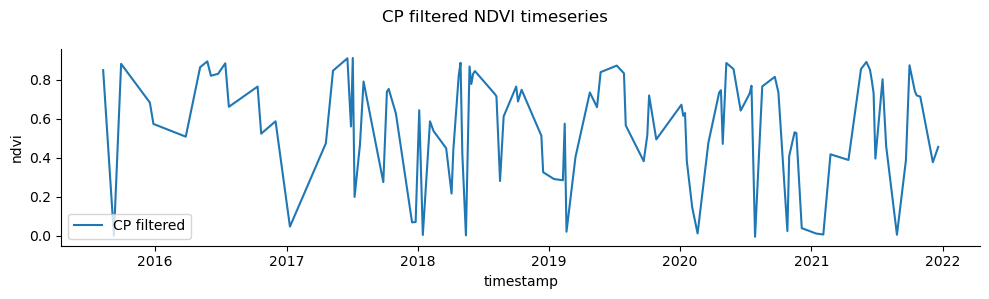

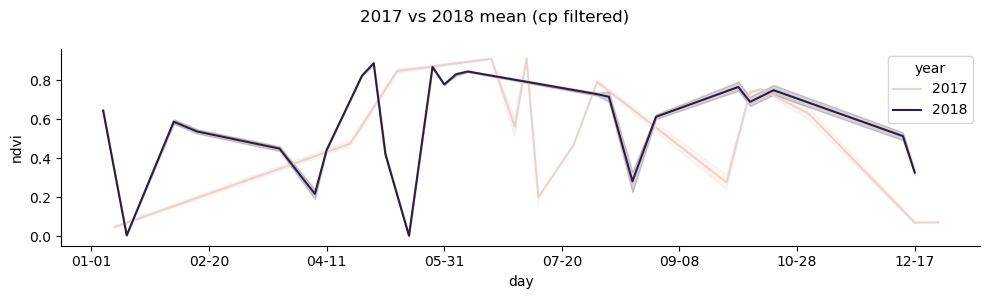

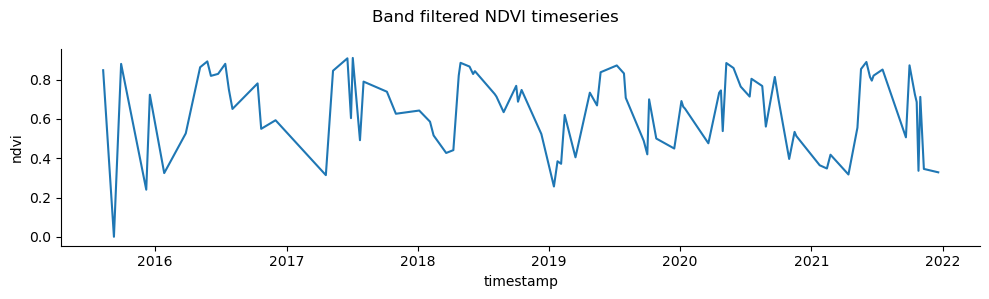

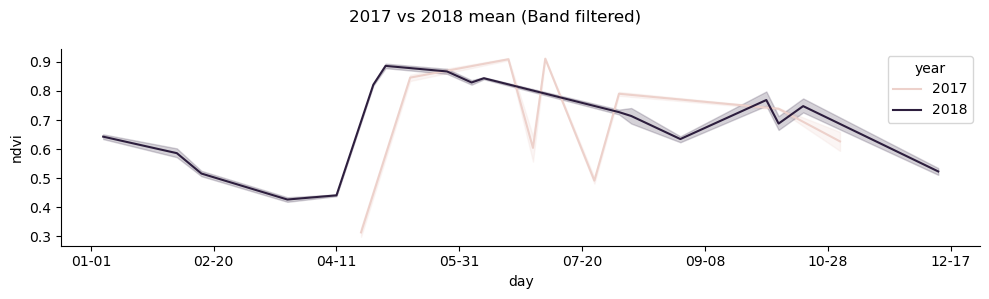

In [12]:
# Compare 2017 vs 2018 
df_brown = df_NDVI.groupby('timestamp').mean().reset_index()
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Raw NDVI timeseries')
sns.lineplot(ax=axs, x='timestamp', y='ndvi', data=df_brown, label='raw')
sns.despine(top=True, right=True)
plt.tight_layout()

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('2017 vs 2018 mean (raw)')
sns.lineplot(ax=axs, x='day', y='ndvi', data=df_NDVI[(df_NDVI.year.isin([2018, 2017]))], hue='year')
sns.despine(top=True, right=True)
axs.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.tight_layout()

df_brown = df_NDVI[df_NDVI.cp<1].groupby('timestamp').mean().reset_index()
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('CP filtered NDVI timeseries')
sns.lineplot(ax=axs, x='timestamp', y='ndvi', data=df_brown, label='CP filtered')
sns.despine(top=True, right=True)
plt.tight_layout()

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('2017 vs 2018 mean (cp filtered)')
sns.lineplot(ax=axs, x='day', y='ndvi', data=df_NDVI[(df_NDVI.cp<1) & (df_NDVI.year.isin([2018, 2017]))], hue='year')
sns.despine(top=True, right=True)
axs.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.tight_layout()


df_brown = df_NDVI[(df_NDVI.b2<0.1) & (df_NDVI.b8>0.15)].groupby('timestamp').mean().reset_index()
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Band filtered NDVI timeseries')
sns.lineplot(ax=axs, x='timestamp', y='ndvi', data=df_brown)
sns.despine(top=True, right=True)
plt.tight_layout()

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('2017 vs 2018 mean (Band filtered)')
sns.lineplot(ax=axs, x='day', y='ndvi', data=df_NDVI[(df_NDVI.b2<0.1) & (df_NDVI.b8>0.15) & (df_NDVI.year.isin([2018, 2017]))], hue='year')
sns.despine(top=True, right=True)
axs.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.tight_layout()

### Compare anomalies

In [19]:
monthly_means_2017 = df_NDVI[(df_NDVI.year==2017) & (df_NDVI.month.isin([5,6,7,8])) & (df_NDVI.cp<10)].groupby('month').mean().ndvi.reset_index()
monthly_stds_2017 = df_NDVI[(df_NDVI.year==2017) & (df_NDVI.month.isin([5,6,7,8])) & (df_NDVI.cp<10)].groupby('month').std().ndvi.reset_index()
summer_mean_2017 = df_NDVI[(df_NDVI.year==2017) & (df_NDVI.month.isin([5,6,7,8])) & (df_NDVI.cp<10)].ndvi.mean()
summer_std_2017 = df_NDVI[(df_NDVI.year==2017) & (df_NDVI.month.isin([5,6,7,8])) & (df_NDVI.cp<10)].ndvi.std()

monthly_means_2018 = df_NDVI[(df_NDVI.year==2018) & (df_NDVI.month.isin([5,6,7,8])) & (df_NDVI.cp<10)].groupby('month').mean().ndvi.reset_index()
monthly_stds_2018 = df_NDVI[(df_NDVI.year==2018) & (df_NDVI.month.isin([5,6,7,8])) & (df_NDVI.cp<10)].groupby('month').std().ndvi.reset_index()
summer_mean_2018 = df_NDVI[(df_NDVI.year==2018) & (df_NDVI.month.isin([5,6,7,8])) & (df_NDVI.cp<10)].ndvi.mean()
summer_std_2018 = df_NDVI[(df_NDVI.year==2018) & (df_NDVI.month.isin([5,6,7,8])) & (df_NDVI.cp<10)].ndvi.std()

(0.0, 1.0)

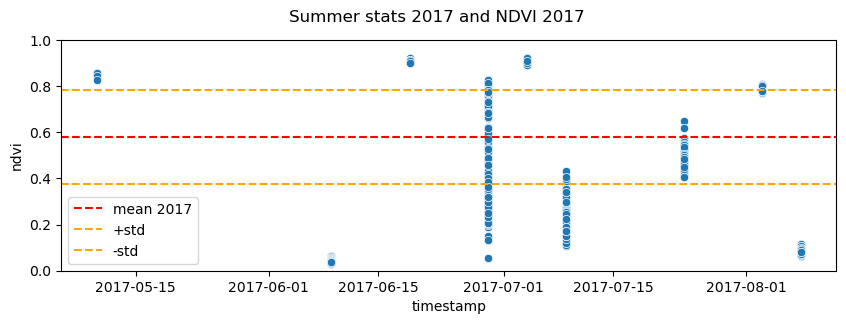

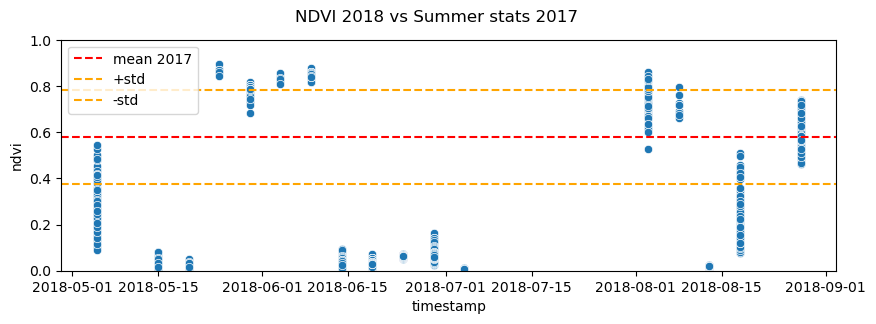

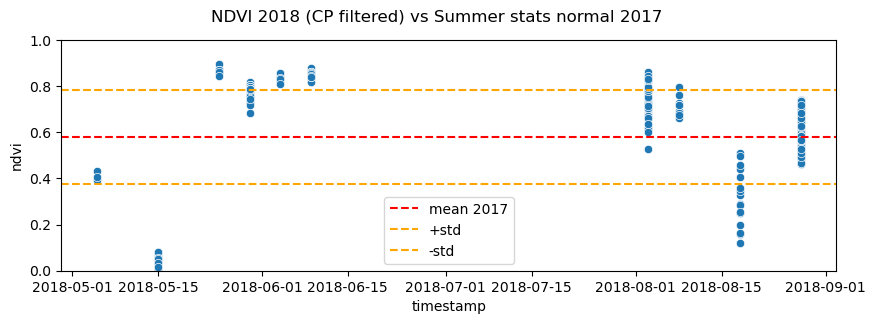

In [20]:
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Summer stats 2017 and NDVI 2017')
axs.axhline(summer_mean_2017, linestyle='--', color='red', label='mean 2017')
axs.axhline(summer_mean_2017+summer_std_2017, linestyle='--', color='orange', label='+std')
axs.axhline(summer_mean_2017-summer_std_2017, linestyle='--', color='orange', label='-std')
sns.scatterplot(ax=axs, x='timestamp', y='ndvi', data=df_NDVI[(df_NDVI.month.isin([5,6,7,8])) & (df_NDVI.year==2017)])
axs.set_ylim(0,1)

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('NDVI 2018 vs Summer stats 2017')
axs.axhline(summer_mean_2017, linestyle='--', color='red', label='mean 2017')
axs.axhline(summer_mean_2017+summer_std_2017, linestyle='--', color='orange', label='+std')
axs.axhline(summer_mean_2017-summer_std_2017, linestyle='--', color='orange', label='-std')
sns.scatterplot(ax=axs, x='timestamp', y='ndvi', data=df_NDVI[(df_NDVI.month.isin([5,6,7,8])) & (df_NDVI.year==2018)])
axs.set_ylim(0,1)

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('NDVI 2018 (CP filtered) vs Summer stats normal 2017')
axs.axhline(summer_mean_2017, linestyle='--', color='red', label='mean 2017')
axs.axhline(summer_mean_2017+summer_std_2017, linestyle='--', color='orange', label='+std')
axs.axhline(summer_mean_2017-summer_std_2017, linestyle='--', color='orange', label='-std')
sns.scatterplot(ax=axs, x='timestamp', y='ndvi', data=df_NDVI[(df_NDVI.month.isin([5,6,7,8])) & (df_NDVI.year==2018) & (df_NDVI.cp<10)])
axs.set_ylim(0,1)

### Compare anomalies (using band filtering)

In [17]:
monthly_means_2017 = df_NDVI[(df_NDVI.year==2017) & (df_NDVI.month.isin([5,6,7,8])) & (df_NDVI.b2<0.1) & (df_NDVI.b8>0.15)].groupby('month').mean().ndvi.reset_index()
monthly_stds_2017 = df_NDVI[(df_NDVI.year==2017) & (df_NDVI.month.isin([5,6,7,8])) & (df_NDVI.b2<0.1) & (df_NDVI.b8>0.15)].groupby('month').std().ndvi.reset_index()
summer_mean_2017 = df_NDVI[(df_NDVI.year==2017) & (df_NDVI.month.isin([5,6,7,8])) & (df_NDVI.b2<0.1) & (df_NDVI.b8>0.15)].ndvi.mean()
summer_std_2017 = df_NDVI[(df_NDVI.year==2017) & (df_NDVI.month.isin([5,6,7,8])) & (df_NDVI.b2<0.1) & (df_NDVI.b8>0.15)].ndvi.std()

monthly_means_2018 = df_NDVI[(df_NDVI.year==2018) & (df_NDVI.month.isin([5,6,7,8])) & (df_NDVI.b2<0.1) & (df_NDVI.b8>0.15)].groupby('month').mean().ndvi.reset_index()
monthly_stds_2018 = df_NDVI[(df_NDVI.year==2018) & (df_NDVI.month.isin([5,6,7,8])) & (df_NDVI.b2<0.1) & (df_NDVI.b8>0.15)].groupby('month').std().ndvi.reset_index()
summer_mean_2018 = df_NDVI[(df_NDVI.year==2018) & (df_NDVI.month.isin([5,6,7,8])) & (df_NDVI.b2<0.1) & (df_NDVI.b8>0.15)].ndvi.mean()
summer_std_2018 = df_NDVI[(df_NDVI.year==2018) & (df_NDVI.month.isin([5,6,7,8])) & (df_NDVI.b2<0.1) & (df_NDVI.b8>0.15)].ndvi.std()

(0.0, 1.0)

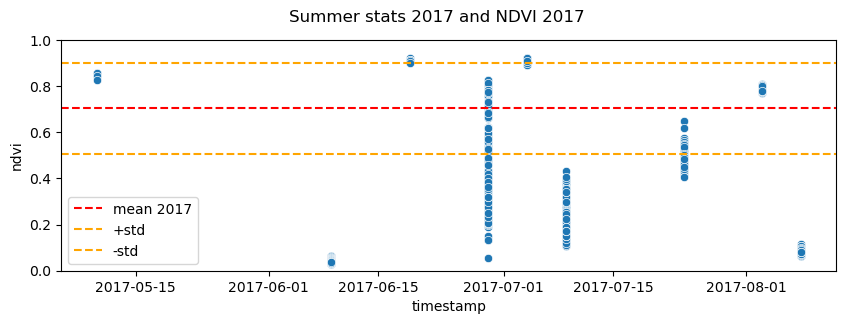

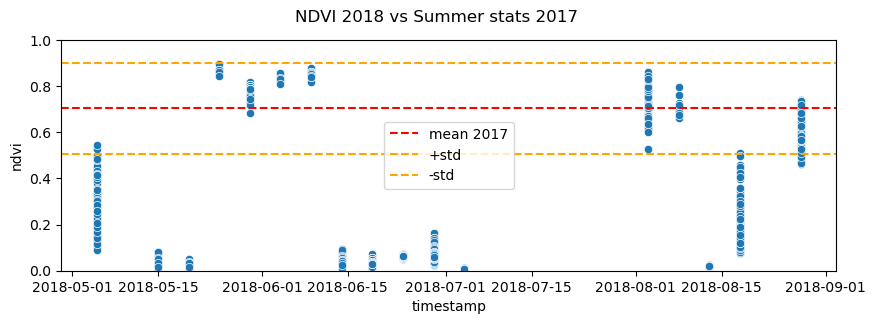

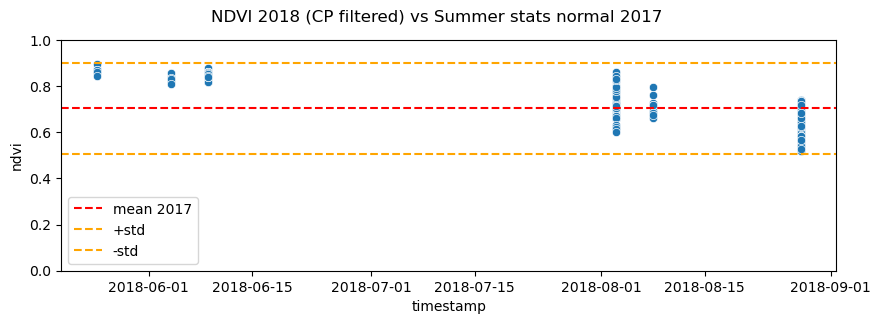

In [18]:
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Summer stats 2017 and NDVI 2017')
axs.axhline(summer_mean_2017, linestyle='--', color='red', label='mean 2017')
axs.axhline(summer_mean_2017+summer_std_2017, linestyle='--', color='orange', label='+std')
axs.axhline(summer_mean_2017-summer_std_2017, linestyle='--', color='orange', label='-std')
sns.scatterplot(ax=axs, x='timestamp', y='ndvi', data=df_NDVI[(df_NDVI.month.isin([5,6,7,8])) & (df_NDVI.year==2017)])
axs.set_ylim(0,1)

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('NDVI 2018 vs Summer stats 2017')
axs.axhline(summer_mean_2017, linestyle='--', color='red', label='mean 2017')
axs.axhline(summer_mean_2017+summer_std_2017, linestyle='--', color='orange', label='+std')
axs.axhline(summer_mean_2017-summer_std_2017, linestyle='--', color='orange', label='-std')
sns.scatterplot(ax=axs, x='timestamp', y='ndvi', data=df_NDVI[(df_NDVI.month.isin([5,6,7,8])) & (df_NDVI.year==2018)])
axs.set_ylim(0,1)

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('NDVI 2018 (Band filtered) vs Summer stats normal 2017')
axs.axhline(summer_mean_2017, linestyle='--', color='red', label='mean 2017')
axs.axhline(summer_mean_2017+summer_std_2017, linestyle='--', color='orange', label='+std')
axs.axhline(summer_mean_2017-summer_std_2017, linestyle='--', color='orange', label='-std')
sns.scatterplot(ax=axs, x='timestamp', y='ndvi', data=df_NDVI[(df_NDVI.month.isin([5,6,7,8])) & (df_NDVI.year==2018) & (df_NDVI.b2<0.1) & (df_NDVI.b8>0.15)])
axs.set_ylim(0,1)

### Analyse a single pixel (that has anomalies)

In [21]:
# Filter cloud and find anomalous pixel in summer

#df_filtered = df_NDVI[df_NDVI.cp<1]
df_filtered = df_NDVI[(df_NDVI.b2<0.1) & (df_NDVI.b8>0.15)]
df_filtered = df_filtered.merge(monthly_means_2017.rename(columns={'ndvi':'mean'}), on="month", how="left")
df_filtered = df_filtered.merge(monthly_stds_2017.rename(columns={'ndvi':'std'}), on="month", how="left")
df_filtered["zscore"] = (df_filtered["ndvi"] - df_filtered["mean"] )/df_filtered["std"] 

In [22]:
df_filtered[df_filtered.month.isin([6,7,8])].groupby('wkt').sum().zscore.reset_index().sort_values("zscore").head(15)

,wkt,zscore
118,POINT (8.6433065384615393 47.7319425000000024),-63.714692
87,POINT (8.6425196153846162 47.7316775000000035),-56.330648
117,POINT (8.6433065384615393 47.7316775000000035),-55.610684
25,POINT (8.6409457692307683 47.7311474999999987),-54.287103
24,POINT (8.6409457692307683 47.7308824999999999),-51.910298
6,POINT (8.6404211538461535 47.7314124999999976),-51.675497
127,POINT (8.6435688461538458 47.7316775000000035),-51.540071
106,POINT (8.6430442307692310 47.7314124999999976),-50.995091
41,POINT (8.6414703846153849 47.7300874999999962),-48.160421
7,POINT (8.6404211538461535 47.7316775000000035),-47.699095


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


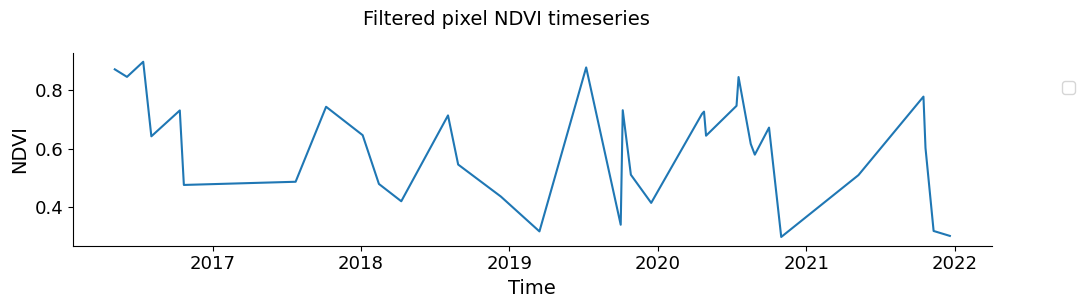

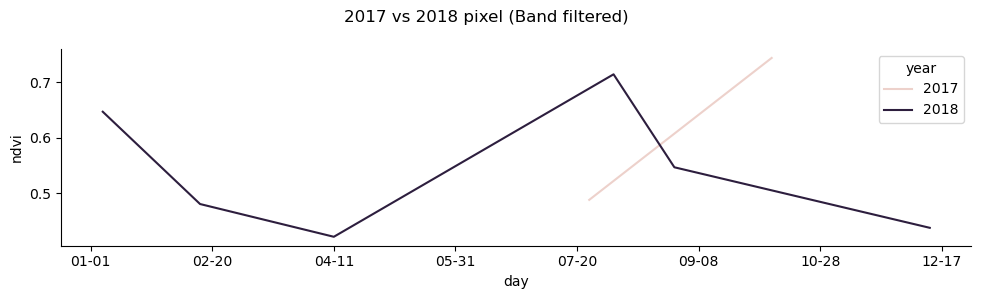

In [25]:
# Plot pixel
df_pix = df_filtered[df_filtered.wkt=='POINT (8.6425196153846162 47.7316775000000035)']

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Filtered pixel NDVI timeseries',fontsize=14)
sns.lineplot(ax=axs, x='timestamp', y='ndvi', data=df_pix)
sns.despine(top=True, right=True)
plt.tight_layout()
axs.set_xlabel('Time', fontsize=14)
axs.set_ylabel('NDVI', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 0.9), fontsize=12)

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('2017 vs 2018 pixel (Band filtered)')
sns.lineplot(ax=axs, x='day', y='ndvi', data=df_pix[(df_pix.b2<0.1) & (df_pix.b8>0.15) & (df_pix.year.isin([2018, 2017]))], hue='year')
sns.despine(top=True, right=True)
axs.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.tight_layout()

## Vaud

In [75]:
bbox =  [6.4953, 46.664, 6.4965, 46.6655] #[6.48655, 46.66465, 6.48950, 46.66738] #[6.488905,46.667063,6.495100, 46.669420] #[6.48655, 46.66738, 6.48950, 46.66465]
coords = "46.630_6.379_47.700_6.507" # Sarraz,Vaud

In [76]:
# Create forest mask and get forest pixels coordinates
forest_binary, gdf = create_forest_mask(bbox, coords)

shape of bbox: (5, 4)


In [77]:
# Get raster data in bbox and in forest
df_NDVI = get_ndvi_and_bands_coords(coords, forest_binary, bbox, gdf)
df_NDVI['year'] = df_NDVI['timestamp'].dt.year
df_NDVI['day'] = df_NDVI['timestamp'].dt.dayofyear
df_NDVI = df_NDVI.rename(columns={f'{coords}':'coords'})
df_NDVI['month'] = df_NDVI['timestamp'].dt.month
df_NDVI['coords'] = df_NDVI.coords.apply(lambda x: x.wkt)

In [78]:
df_NDVI

,timestamp,ndvi,cp,b2,b8,coords,year,day,month
0,2018-03-11,0.0347,99.0,0.9531,1.0048,POINT (6.49545 46.66535),2018,70,3
1,2018-03-11,0.0345,99.0,0.9485,1.0082,POINT (6.49575 46.66535),2018,70,3
2,2018-03-11,0.0326,99.0,0.9459,1.0035,POINT (6.49605 46.66535),2018,70,3
3,2018-03-11,0.0335,98.0,0.9415,1.0004,POINT (6.49635 46.66535),2018,70,3
4,2018-03-11,0.0347,97.0,0.9479,1.0101,POINT (6.49545 46.66505),2018,70,3
...,...,...,...,...,...,...,...,...,...
4855,2017-04-30,0.5858,0.0,0.0571,0.2720,POINT (6.49635 46.66445),2017,120,4
4856,2017-04-30,0.5535,1.0,0.0461,0.2929,POINT (6.49545 46.66415000000001),2017,120,4
4857,2017-04-30,0.6081,0.0,0.0545,0.2993,POINT (6.49575 46.66415000000001),2017,120,4
4858,2017-04-30,0.6016,0.0,0.0502,0.2879,POINT (6.49605 46.66415000000001),2017,120,4


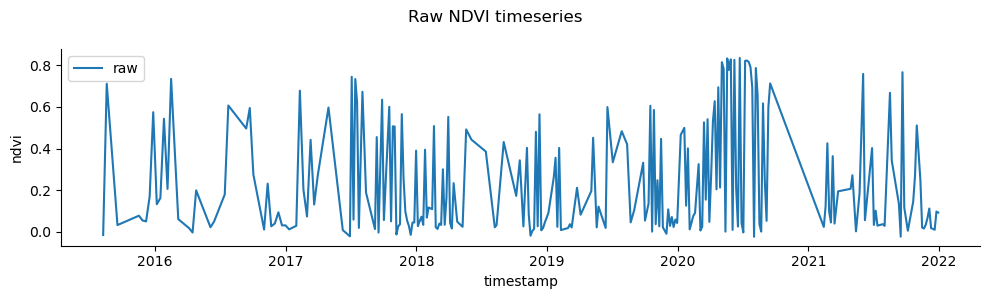

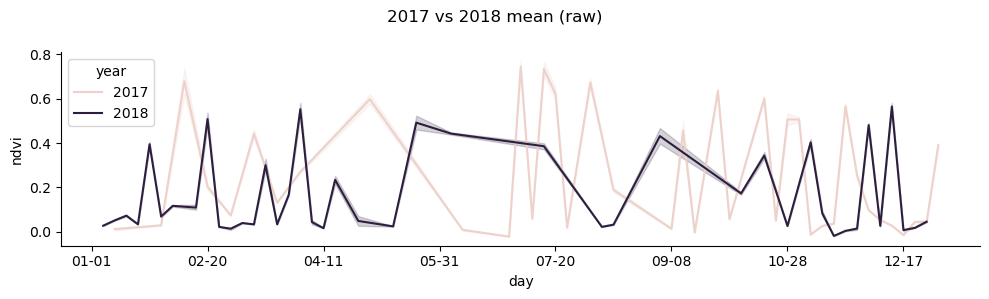

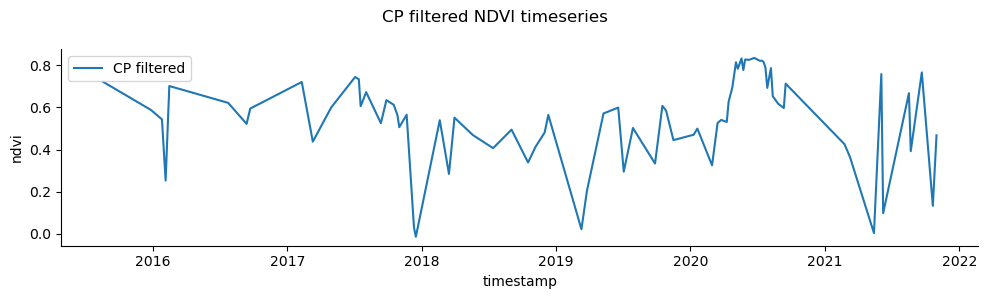

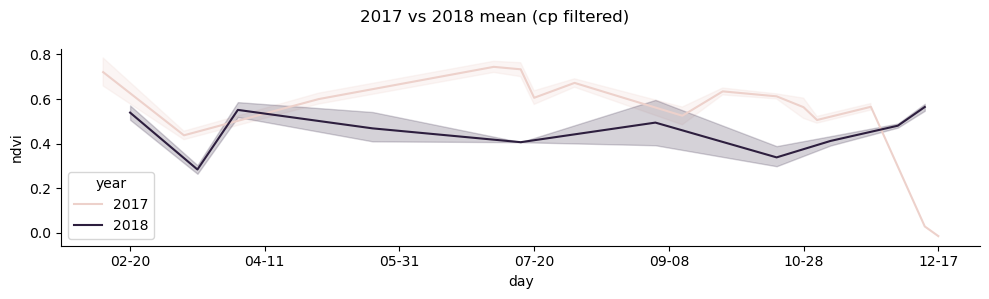

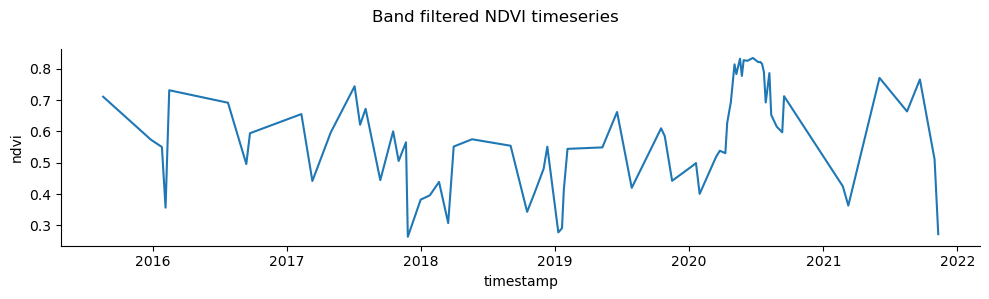

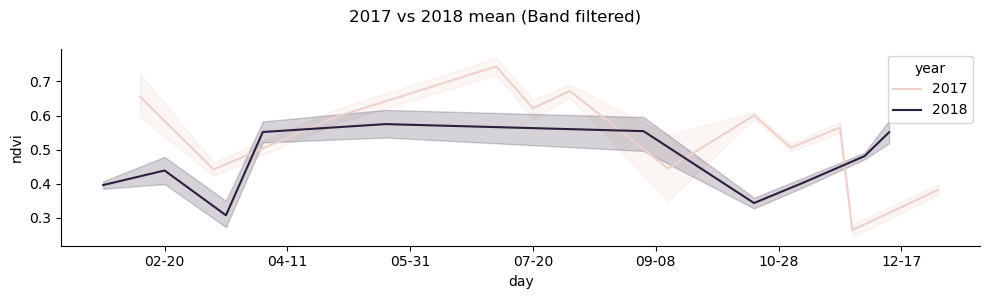

In [79]:
# Compare 2017 vs 2018 
df_brown = df_NDVI.groupby('timestamp').mean().reset_index()
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Raw NDVI timeseries')
sns.lineplot(ax=axs, x='timestamp', y='ndvi', data=df_brown, label='raw')
sns.despine(top=True, right=True)
plt.tight_layout()


fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('2017 vs 2018 mean (raw)')
sns.lineplot(ax=axs, x='day', y='ndvi', data=df_NDVI[(df_NDVI.year.isin([2018, 2017]))], hue='year')
sns.despine(top=True, right=True)
axs.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.tight_layout()


df_brown = df_NDVI[df_NDVI.cp<1].groupby('timestamp').mean().reset_index()
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('CP filtered NDVI timeseries')
sns.lineplot(ax=axs, x='timestamp', y='ndvi', data=df_brown, label='CP filtered')
sns.despine(top=True, right=True)
plt.tight_layout()


fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('2017 vs 2018 mean (cp filtered)')
sns.lineplot(ax=axs, x='day', y='ndvi', data=df_NDVI[(df_NDVI.cp<1) & (df_NDVI.year.isin([2018, 2017]))], hue='year')
sns.despine(top=True, right=True)
axs.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.tight_layout()

df_brown = df_NDVI[(df_NDVI.b2<0.1) & (df_NDVI.b8>0.15)].groupby('timestamp').mean().reset_index()
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Band filtered NDVI timeseries')
sns.lineplot(ax=axs, x='timestamp', y='ndvi', data=df_brown)
sns.despine(top=True, right=True)
plt.tight_layout()

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('2017 vs 2018 mean (Band filtered)')
sns.lineplot(ax=axs, x='day', y='ndvi', data=df_NDVI[(df_NDVI.b2<0.1) & (df_NDVI.b8>0.15) & (df_NDVI.year.isin([2018, 2017]))], hue='year')
sns.despine(top=True, right=True)
axs.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.tight_layout()

### Compare anomalies 

In [86]:
monthly_means_2017 = df_NDVI[(df_NDVI.year==2017) & (df_NDVI.month.isin([5,6,7,8,9])) & (df_NDVI.cp<10)].groupby('month').mean().ndvi.reset_index()
monthly_stds_2017 = df_NDVI[(df_NDVI.year==2017) & (df_NDVI.month.isin([5,6,7,8,9])) & (df_NDVI.cp<10)].groupby('month').std().ndvi.reset_index()
summer_mean_2017 = df_NDVI[(df_NDVI.year==2017) & (df_NDVI.month.isin([5,6,7,8,9])) & (df_NDVI.cp<10)].ndvi.mean()
summer_std_2017 = df_NDVI[(df_NDVI.year==2017) & (df_NDVI.month.isin([5,6,7,8,9])) & (df_NDVI.cp<10)].ndvi.std()

monthly_means_2018 = df_NDVI[(df_NDVI.year==2018) & (df_NDVI.month.isin([5,6,7,8,9])) & (df_NDVI.cp<10)].groupby('month').mean().ndvi.reset_index()
monthly_stds_2018 = df_NDVI[(df_NDVI.year==2018) & (df_NDVI.month.isin([5,6,7,8,9])) & (df_NDVI.cp<10)].groupby('month').std().ndvi.reset_index()
summer_mean_2018 = df_NDVI[(df_NDVI.year==2018) & (df_NDVI.month.isin([5,6,7,8,9])) & (df_NDVI.cp<10)].ndvi.mean()
summer_std_2018 = df_NDVI[(df_NDVI.year==2018) & (df_NDVI.month.isin([5,6,7,8,9])) & (df_NDVI.cp<10)].ndvi.std()

In [87]:
data_2017=df_NDVI[(df_NDVI.month.isin([5,6,7,8,9])) & (df_NDVI.year==2017)]
data_2018=df_NDVI[(df_NDVI.month.isin([5,6,7,8,9])) & (df_NDVI.year==2018)]

(0.0, 1.0)

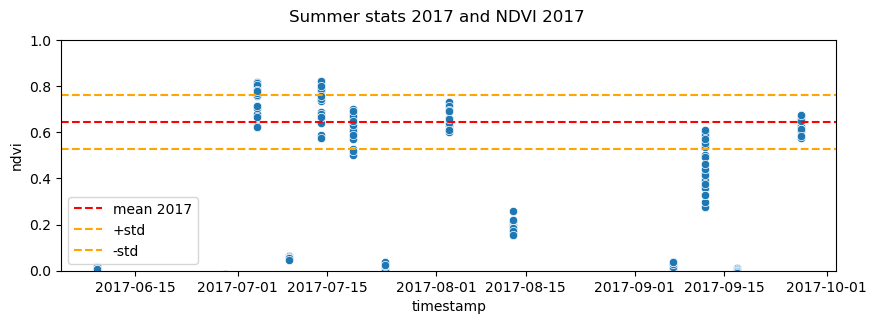

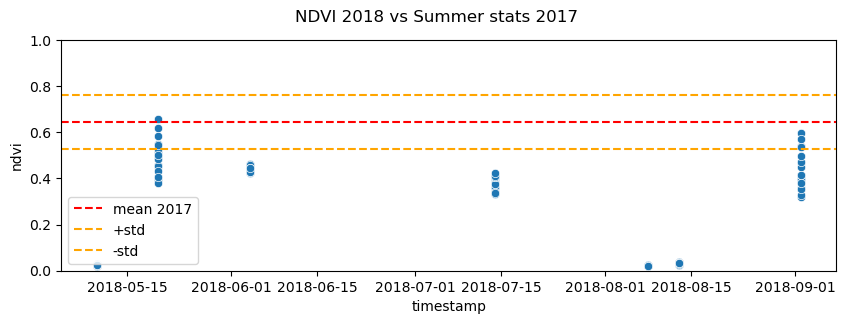

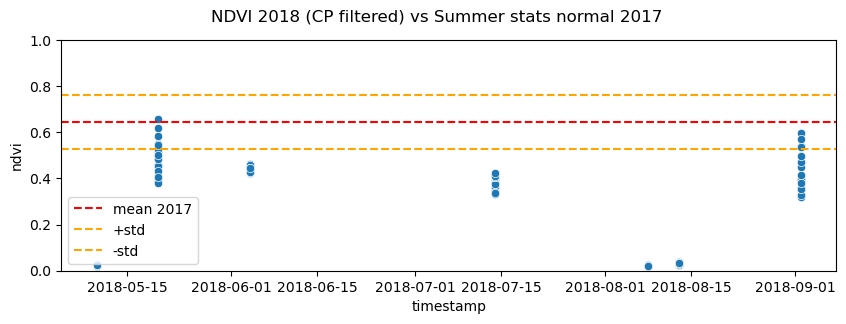

In [88]:
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Summer stats 2017 and NDVI 2017')
axs.axhline(summer_mean_2017, linestyle='--', color='red', label='mean 2017')
axs.axhline(summer_mean_2017+summer_std_2017, linestyle='--', color='orange', label='+std')
axs.axhline(summer_mean_2017-summer_std_2017, linestyle='--', color='orange', label='-std')
sns.scatterplot(ax=axs, x=data_2017['timestamp'], y=data_2017['ndvi'])
axs.set_ylim(0,1)

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('NDVI 2018 vs Summer stats 2017')
axs.axhline(summer_mean_2017, linestyle='--', color='red', label='mean 2017')
axs.axhline(summer_mean_2017+summer_std_2017, linestyle='--', color='orange', label='+std')
axs.axhline(summer_mean_2017-summer_std_2017, linestyle='--', color='orange', label='-std')
sns.scatterplot(ax=axs, x=data_2018['timestamp'], y=data_2018['ndvi'])
axs.set_ylim(0,1)

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('NDVI 2018 (CP filtered) vs Summer stats normal 2017')
axs.axhline(summer_mean_2017, linestyle='--', color='red', label='mean 2017')
axs.axhline(summer_mean_2017+summer_std_2017, linestyle='--', color='orange', label='+std')
axs.axhline(summer_mean_2017-summer_std_2017, linestyle='--', color='orange', label='-std')
sns.scatterplot(ax=axs, x=data_2018['timestamp'], y=data_2018['ndvi'])
axs.set_ylim(0,1)

### Copare anomalies (band filtering)

In [89]:
monthly_means_2017 = df_NDVI[(df_NDVI.year==2017) & (df_NDVI.month.isin([5,6,7,8,9])) & (df_NDVI.b2<0.1) & (df_NDVI.b8>0.15)].groupby('month').mean().ndvi.reset_index()
monthly_stds_2017 = df_NDVI[(df_NDVI.year==2017) & (df_NDVI.month.isin([5,6,7,8,9])) & (df_NDVI.b2<0.1) & (df_NDVI.b8>0.15)].groupby('month').std().ndvi.reset_index()
summer_mean_2017 = df_NDVI[(df_NDVI.year==2017) & (df_NDVI.month.isin([5,6,7,8,9])) & (df_NDVI.b2<0.1) & (df_NDVI.b8>0.15)].ndvi.mean()
summer_std_2017 = df_NDVI[(df_NDVI.year==2017) & (df_NDVI.month.isin([5,6,7,8,9])) & (df_NDVI.b2<0.1) & (df_NDVI.b8>0.15)].ndvi.std()

monthly_means_2018 = df_NDVI[(df_NDVI.year==2018) & (df_NDVI.month.isin([5,6,7,8,9])) & (df_NDVI.b2<0.1) & (df_NDVI.b8>0.15)].groupby('month').mean().ndvi.reset_index()
monthly_stds_2018 = df_NDVI[(df_NDVI.year==2018) & (df_NDVI.month.isin([5,6,7,8,9])) & (df_NDVI.b2<0.1) & (df_NDVI.b8>0.15)].groupby('month').std().ndvi.reset_index()
summer_mean_2018 = df_NDVI[(df_NDVI.year==2018) & (df_NDVI.month.isin([5,6,7,8,9])) & (df_NDVI.b2<0.1) & (df_NDVI.b8>0.15)].ndvi.mean()
summer_std_2018 = df_NDVI[(df_NDVI.year==2018) & (df_NDVI.month.isin([5,6,7,8,9])) & (df_NDVI.b2<0.1) & (df_NDVI.b8>0.15)].ndvi.std()

(0.0, 1.0)

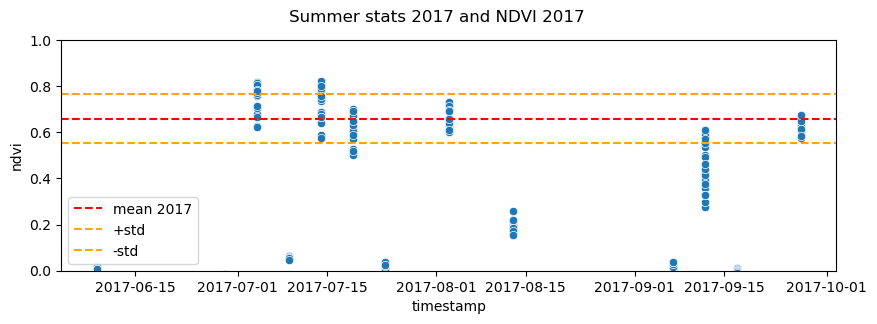

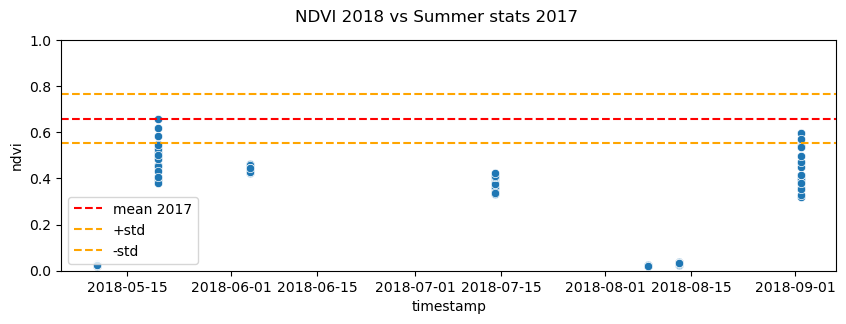

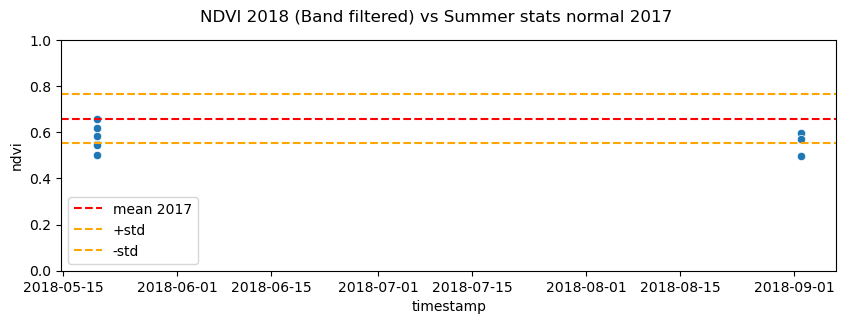

In [90]:
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('Summer stats 2017 and NDVI 2017')
axs.axhline(summer_mean_2017, linestyle='--', color='red', label='mean 2017')
axs.axhline(summer_mean_2017+summer_std_2017, linestyle='--', color='orange', label='+std')
axs.axhline(summer_mean_2017-summer_std_2017, linestyle='--', color='orange', label='-std')
sns.scatterplot(ax=axs, x='timestamp', y='ndvi', data=df_NDVI[(df_NDVI.month.isin([5,6,7,8,9])) & (df_NDVI.year==2017)])
axs.set_ylim(0,1)

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('NDVI 2018 vs Summer stats 2017')
axs.axhline(summer_mean_2017, linestyle='--', color='red', label='mean 2017')
axs.axhline(summer_mean_2017+summer_std_2017, linestyle='--', color='orange', label='+std')
axs.axhline(summer_mean_2017-summer_std_2017, linestyle='--', color='orange', label='-std')
sns.scatterplot(ax=axs, x='timestamp', y='ndvi', data=df_NDVI[(df_NDVI.month.isin([5,6,7,8,9])) & (df_NDVI.year==2018)])
axs.set_ylim(0,1)

fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('NDVI 2018 (Band filtered) vs Summer stats normal 2017')
axs.axhline(summer_mean_2017, linestyle='--', color='red', label='mean 2017')
axs.axhline(summer_mean_2017+summer_std_2017, linestyle='--', color='orange', label='+std')
axs.axhline(summer_mean_2017-summer_std_2017, linestyle='--', color='orange', label='-std')
sns.scatterplot(ax=axs, x='timestamp', y='ndvi', data=df_NDVI[(df_NDVI.month.isin([5,6,7,8,9])) & (df_NDVI.year==2018) & (df_NDVI.b2<0.1) & (df_NDVI.b8>0.15)])
axs.set_ylim(0,1)

### Compare monthly means 2017 vs 2018 (band filtered)

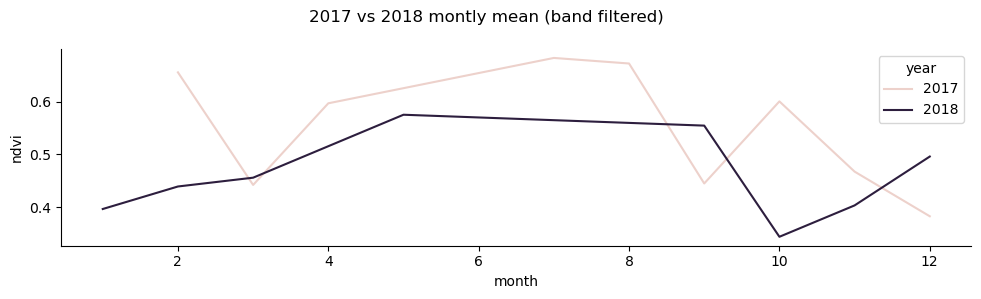

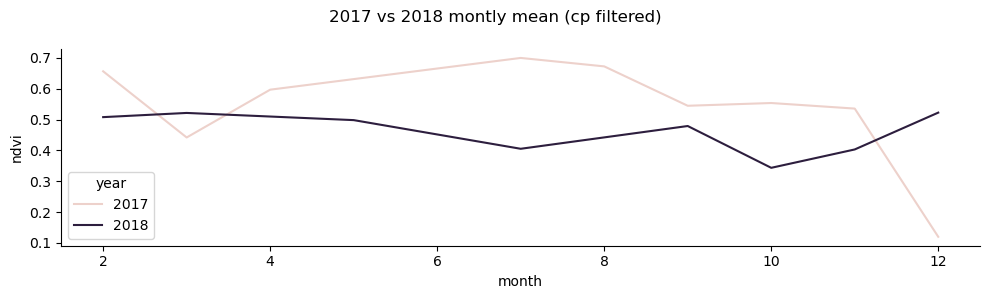

In [91]:
# Compare 2017 vs 2018 
monthly_means = df_NDVI[(df_NDVI.year.isin([2018, 2017])) & (df_NDVI.b2<0.1) & (df_NDVI.b8>0.15)].groupby(['year', 'month']).mean().ndvi.reset_index()
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('2017 vs 2018 montly mean (band filtered)')
sns.lineplot(ax=axs, x='month', y='ndvi', data=monthly_means, hue='year')
sns.despine(top=True, right=True)
plt.tight_layout()

monthly_means = df_NDVI[(df_NDVI.year.isin([2018, 2017])) & (df_NDVI.cp<10)].groupby(['year', 'month']).mean().ndvi.reset_index()
fig, axs = plt.subplots(1, 1, figsize=(10, 3))
plt.suptitle('2017 vs 2018 montly mean (cp filtered)')
sns.lineplot(ax=axs, x='month', y='ndvi', data=monthly_means, hue='year')
sns.despine(top=True, right=True)
plt.tight_layout()